In [1]:
%matplotlib inline

from pathlib import Path
import pydicom as dicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_splita
from typing import Any, Tuple
from skimage.transform import rescale, resize
from tqdm import tqdm

In [2]:
# Deal with 224x224 images for this task
def img_loader(filename):    
    ds=dicom.dcmread(filename)
    ds=ds.pixel_array.astype(np.float32) / ds.pixel_array.max()
    ds = resize(ds, (224, 224)).astype(np.float32)    
    return ds

transform = transforms.Compose([transforms.ToTensor(),])

class PneumoniaDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, img_labels_filepath, data_type, img_loader, transform):
        super(PneumoniaDataset, self).__init__()
        img_labels = pd.read_csv(img_labels_filepath)
        self.img_path_list = [f"{img_folder}/{s}.dcm" for s in list(img_labels["patientId"][:100])]
        self.classes = [s for s in list(img_labels["Target"][:100])]
        self.img_loader = img_loader
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path = self.img_path_list[index]

        # load and transform img
        sample = self.img_loader(path)
        sample = self.transform(sample)

        target = self.classes[index]
        return sample, target

In [3]:
img_targets_file = "./data/stage_2_train_labels.csv"
img_folder=  "./data/stage_2_train_images"
img_labels = pd.read_csv(img_targets_file)

tr = transforms.Compose([transforms.ToTensor()])
data_folder = "data/stage_2_train_images"
labels_file = "data/stage_2_train_labels.csv"
data_type = 'train'
pn_dataset = PneumoniaDataset(data_folder, labels_file, data_type, img_loader, transform)

train_data, test_data = random_split(pn_dataset, [0.7, 0.3])


train_loader = torch.utils.data.DataLoader(pn_dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(pn_dataset, batch_size=4, shuffle=True)

In [4]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

def img_show(img):
    # npimg = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()


images.shape, labels.shape

(torch.Size([4, 1, 224, 224]), torch.Size([4]))

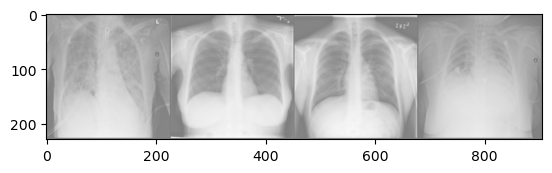

tensor(1) tensor(0) tensor(0) tensor(1)


In [5]:
# show images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(train_loader)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [6]:
# the model
import torch.nn as nn
import torch.nn.functional as F


class PneumoniaNet(nn.Module):
    def __init__(self):
        super(PneumoniaNet, self).__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features = 512, out_features = 1, bias = True)

    def forward(self, data):
        pred = self.model(data)
        return pred

model = PneumoniaNet()

In [7]:
from torchsummary import summary
summary(model, images[0].shape)

[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [8]:
import torch.optim as optim

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor([3]))

In [9]:
# import time 

# start = time.time()

# for epoch in range(100):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(train_loader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         labels = labels.unsqueeze(1).float()
        
#         # forward + backward + optimize
#         outputs = model(inputs)
#         # print("outputs=",outputs.shape, " inputs=", inputs.shape, " labels=", labels.shape)
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()  # zero the parameter gradients
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 10 == 9:    # print every 50 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 10))
#             running_loss = 0.0

# print('Finished Training')

# end = time.time()
# print('training time ', end-start)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)

        labels = labels.unsqueeze(1).float()
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc
    

In [12]:
# Validation function.
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)

            labels = labels.unsqueeze(1).float()
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [13]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
epochs = 20
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        test_loader, 
        criterion,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
# Save the loss and accuracy plots.
save_plots(
    train_acc, 
    valid_acc, 
    train_loss, 
    valid_loss, 
    name=plot_name
)
print('TRAINING COMPLETE')






[INFO]: Epoch 1 of 20
Training


100%|██████████| 25/25 [01:04<00:00,  2.59s/it]


Validation


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Training loss: 0.686, training acc: 204.000
Validation loss: 1.197, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


100%|██████████| 25/25 [01:03<00:00,  2.53s/it]


Validation


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Training loss: 0.491, training acc: 204.000
Validation loss: 0.548, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


Validation


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Training loss: 0.628, training acc: 204.000
Validation loss: 0.490, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


100%|██████████| 25/25 [01:03<00:00,  2.56s/it]


Validation


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


Training loss: 0.571, training acc: 204.000
Validation loss: 0.144, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


100%|██████████| 25/25 [01:04<00:00,  2.60s/it]


Validation


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Training loss: 0.472, training acc: 204.000
Validation loss: 0.143, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


100%|██████████| 25/25 [01:02<00:00,  2.50s/it]


Validation


100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


Training loss: 0.397, training acc: 204.000
Validation loss: 0.071, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


100%|██████████| 25/25 [01:02<00:00,  2.48s/it]


Validation


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Training loss: 0.331, training acc: 204.000
Validation loss: 0.214, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


100%|██████████| 25/25 [04:28<00:00, 10.72s/it]


Validation


100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


Training loss: 0.312, training acc: 204.000
Validation loss: 0.144, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


100%|██████████| 25/25 [01:05<00:00,  2.63s/it]


Validation


100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Training loss: 0.261, training acc: 204.000
Validation loss: 0.033, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


100%|██████████| 25/25 [01:04<00:00,  2.60s/it]


Validation


100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


Training loss: 0.286, training acc: 204.000
Validation loss: 0.076, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


100%|██████████| 25/25 [01:05<00:00,  2.62s/it]


Validation


100%|██████████| 25/25 [00:30<00:00,  1.23s/it]


Training loss: 0.311, training acc: 204.000
Validation loss: 0.071, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


100%|██████████| 25/25 [01:04<00:00,  2.58s/it]


Validation


100%|██████████| 25/25 [00:29<00:00,  1.18s/it]


Training loss: 0.105, training acc: 204.000
Validation loss: 0.005, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


100%|██████████| 25/25 [01:08<00:00,  2.76s/it]


Validation


100%|██████████| 25/25 [00:29<00:00,  1.17s/it]


Training loss: 0.148, training acc: 204.000
Validation loss: 0.128, validation acc: 204.000
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


 88%|████████▊ | 22/25 [01:00<00:08,  2.77s/it]

KeyboardInterrupt



In [ ]:
# lets look at the test data

dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(4)))

In [ ]:
# see what our model thinks these images are
outputs = model(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j] for j in range(4)))